# Обучение модели на основе RuBERT-tiny

Будет использована модель RuBERT-tiny2, предложенная пользователем Cointegrated на сайте [huggingface.co](https://huggingface.co). Модель можно найти по ссылке  
https://huggingface.co/cointegrated/rubert-tiny2

В настоящей Юпитер-тетрадке мы во многом будем следовать за пользователем Cointegrated, дообучившем модель RuBERT-tiny для распознавания настроения в коротких текстах, см. по ссылке  
https://huggingface.co/cointegrated/rubert-tiny-sentiment-balanced  
Будем значительно опираться на его код, опубликованный в  
https://gist.github.com/avidale/e678c5478086c1d1adc52a85cb2b93e6

In [1]:
!pip install evaluate
!pip install datasets
!pip install transformers

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import torch
from torch.utils import data
from sklearn import model_selection, utils
import evaluate
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding

In [4]:
from tqdm.auto import tqdm, trange
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, accuracy_score, f1_score
from IPython.display import display

In [5]:
df_poems = pd.read_csv('poems_dataset.csv')
df_poems

,author,epoch,title,part,text
0,Агнивцев,серебряный век,брат антонио,0,"В монастырской тихой келье,\nПозабывши о весел..."
1,Агнивцев,серебряный век,грузовик 1317,0,"Весь машинный свой век, каждый день по утрам\n..."
2,Агнивцев,серебряный век,грузовик 1317,1,"Грузовик № 1317.\nНо открылись фронты! О, услы..."
3,Агнивцев,серебряный век,мэри пикфорд,0,"В Америке где-то\nСудя по газетам,\nЕсть город..."
4,Агнивцев,серебряный век,бильбокэ,0,"К дофину Франции, в печали,\nСкользнув тайком,..."
...,...,...,...,...,...
54232,Яшин,соцреализм,зеркальце,2,"В руки зеркальце взяла\nИ сказала:\n«Удружи,\n..."
54233,Яшин,соцреализм,очень много солнечного света,0,"Очень много солнечного света,\nНад землей стои..."
54234,Яшин,соцреализм,огонек,0,"Светлячок во мгле —\nОгонек в лесах.\nМожет, о..."
54235,Яшин,соцреализм,назови меня именем светлым,0,"Назови меня именем светлым,\nЧистым именем наз..."


In [6]:
np.random.seed(101)
df_train, df_eval_test = model_selection.train_test_split(df_poems, test_size=0.3)
df_eval, df_test = model_selection.train_test_split(df_eval_test, test_size=0.5)

In [7]:
df_labels = pd.concat([
    df_train.groupby('epoch').size(),
    df_eval.groupby('epoch').size(),
    df_test.groupby('epoch').size()
], axis=1)
df_labels.columns = ['train', 'eval', 'test']
df_labels

,train,eval,test
epoch,,,
золотой век,6009,1243,1309
классицизм,2294,479,508
критический реализм,6617,1412,1399
серебряный век,11278,2460,2466
соцреализм,4131,894,858
футуризм,5376,1153,1113
шестидесятники,2260,495,483


In [8]:
datasets = DatasetDict({
    'train': Dataset.from_pandas(df_train[['text', 'epoch']]),
    'eval': Dataset.from_pandas(df_eval[['text', 'epoch']]),
    'test': Dataset.from_pandas(df_test[['text', 'epoch']])
})

In [9]:
class LabelEncoder:
    def __init__(self, labels):
        self._index_to_label = np.array(labels)
        self._label_to_index = pd.DataFrame(np.arange(len(labels)), index=labels)

    def encode(self, arr_labels):
        return self._label_to_index.loc[arr_labels].to_numpy()

    def decode(self, arr_indices):
        return self._index_to_label[arr_indices]

    def get_dicts(self):
        index_to_label = {
            index: label for index, label in enumerate(self._index_to_label)
        }
        label_to_index = {
            label: index for index, label in enumerate(self._index_to_label)
        }
        return index_to_label, label_to_index

In [10]:
label_encoder = LabelEncoder([
    'классицизм',
    'золотой век',
    'критический реализм',
    'серебряный век',
    'футуризм',
    'соцреализм',
    'шестидесятники'
])

Модель рассчитана в том числе для работы на GPU -- используем это.

In [12]:
torch.manual_seed(1234)
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
model = AutoModelForSequenceClassification.from_pretrained(
    "cointegrated/rubert-tiny2",
    num_labels=7
)
if torch.cuda.is_available():
    model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
datasets_tokenized = datasets.map(
    lambda x: tokenizer(x['text'], truncation=True),
    batched=True,
    remove_columns=['text']
).map(
    lambda x: {'label': label_encoder.encode(x['epoch'])},
    batched=True,
    remove_columns=['epoch']
)

Map:   0%|          | 0/37965 [00:00<?, ? examples/s]

Map:   0%|          | 0/8136 [00:00<?, ? examples/s]

Map:   0%|          | 0/8136 [00:00<?, ? examples/s]

Map:   0%|          | 0/37965 [00:00<?, ? examples/s]

Map:   0%|          | 0/8136 [00:00<?, ? examples/s]

Map:   0%|          | 0/8136 [00:00<?, ? examples/s]

In [14]:
def evaluate_model(model, dev_dataloader, verbose=False, labels=None):
    facts, preds = predict_with_model(model, dev_dataloader)
    pfrs, aucs = get_classification_report(facts, preds, labels)
    if verbose:
        display(pfrs)
        print('aucs:', aucs, np.mean(aucs))
    return np.mean(aucs)

def predict_with_model(model, dataloader):
    preds = []
    facts = []

    for batch in tqdm(dataloader):
        facts.append(batch.labels.cpu().numpy())
        batch = batch.to(model.device)
        with torch.no_grad():
            pr = model(
                input_ids=batch.input_ids,
                attention_mask=batch.attention_mask,
                token_type_ids=batch.token_type_ids
            )
        preds.append(torch.softmax(pr.logits, -1).cpu().numpy())
    facts = np.concatenate(facts)
    preds = np.concatenate(preds)
    return facts, preds

def get_classification_report(facts, preds, labels=None):
    pfrs = pd.DataFrame(dict(zip(
        ['p', 'r', 'f', 's'],
        precision_recall_fscore_support(facts, preds.argmax(1))
    )))
    aucs = [roc_auc_score(facts==i, preds[:, i]) for i in np.unique(facts)]
    pfrs['a'] = aucs
    pfrs = pd.concat([
        pfrs,
        pd.DataFrame(pfrs.mean(axis=0), columns=['mean']).T
    ])
    if labels is not None:
        pfrs.index = list(labels) + ['mean']
    return pfrs, aucs

In [16]:
data_collator = DataCollatorWithPadding(tokenizer)
loader_train = data.DataLoader(
    datasets_tokenized['train'],
    batch_size=64, drop_last=False, shuffle=True, num_workers=0,
    collate_fn=data_collator
)
loader_eval = data.DataLoader(
    datasets_tokenized['eval'],
    batch_size=64, drop_last=False, shuffle=True, num_workers=0,
    collate_fn=data_collator
)
loader_test = data.DataLoader(
    datasets_tokenized['test'],
    batch_size=64, drop_last=False, shuffle=True, num_workers=0,
    collate_fn=data_collator
)

In [17]:
evaluate_model(model, loader_eval, verbose=True)

  0%|          | 0/128 [00:00<?, ?it/s]

,p,r,f,s,a
0,0.000000,0.000000,0.000000,479.000000,0.489045
1,0.144558,0.068383,0.092845,1243.000000,0.528661
2,0.131579,0.003541,0.006897,1412.000000,0.515282
3,0.309501,0.936179,0.465206,2460.000000,0.591596
4,0.535714,0.013010,0.025402,1153.000000,0.515169
5,0.153846,0.004474,0.008696,894.000000,0.466121
6,0.000000,0.000000,0.000000,495.000000,0.451627
mean,0.182171,0.146512,0.085578,1162.285714,0.508214


aucs: [np.float64(0.48904450551203305), np.float64(0.528660951057534), np.float64(0.5152816619845533), np.float64(0.5915962661212235), np.float64(0.515169227111959), np.float64(0.4661206811867388), np.float64(0.4516272527658472)] 0.5082143636771269


np.float64(0.5082143636771269)

In [18]:
import gc

def cleanup():
    gc.collect()
    torch.cuda.empty_cache()

cleanup()

In [19]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-5)

In [20]:
gradient_accumulation_steps = 1
window = 10
cleanup_step = 100
report_step = 10000

In [21]:
ewm_loss = 0
model.train()
cleanup()

for epoch in trange(8):
    tq = tqdm(loader_train)

    for i, batch in enumerate(tq):
        try:
            batch = batch.to(model.device)
            output = model(
                input_ids=batch.input_ids,
                attention_mask=batch.attention_mask,
                token_type_ids=batch.token_type_ids,
                labels=batch.labels
            )
            loss = output.loss
            loss.backward()
        except RuntimeError as e:
            print('error on step', i, e)
            loss = None
            cleanup()
            continue

        if i and i % gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        if i % cleanup_step == 0:
            cleanup()

        w = 1 / min(i+1, window)
        ewm_loss = ewm_loss * (1-w) + loss.item() * w
        tq.set_description(f'loss: {ewm_loss:4.4f}')

        if i % report_step == 0:
            model.eval()
            eval_loss = evaluate_model(model, loader_eval, verbose=True)
            model.train()
            print(f'epoch {epoch}, step {i}: train loss: {ewm_loss:4.4f}  val auc: {eval_loss}')

model.eval()
eval_loss = evaluate_model(model, loader_eval, verbose=True)
print(f'epoch {epoch + 1}, step {i}: train loss: {ewm_loss:4.4f}  val auc: {eval_loss}')

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

,p,r,f,s,a
0,0.000000,0.000000,0.000000,479.000000,0.489045
1,0.144558,0.068383,0.092845,1243.000000,0.528661
2,0.131579,0.003541,0.006897,1412.000000,0.515282
3,0.309501,0.936179,0.465206,2460.000000,0.591596
4,0.535714,0.013010,0.025402,1153.000000,0.515169
5,0.153846,0.004474,0.008696,894.000000,0.466121
6,0.000000,0.000000,0.000000,495.000000,0.451627
mean,0.182171,0.146512,0.085578,1162.285714,0.508214


aucs: [np.float64(0.48904450551203305), np.float64(0.528660951057534), np.float64(0.5152816619845533), np.float64(0.5915962661212235), np.float64(0.515169227111959), np.float64(0.4661206811867388), np.float64(0.4516272527658472)] 0.5082143636771269
epoch 0, step 0: train loss: 1.9155  val auc: 0.5082143636771269


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,p,r,f,s,a
0,0.000000,0.000000,0.000000,479.000000,0.866350
1,0.471855,0.546259,0.506339,1243.000000,0.843393
2,0.576550,0.421388,0.486907,1412.000000,0.817849
3,0.545947,0.818699,0.655066,2460.000000,0.841226
4,0.542456,0.670425,0.599690,1153.000000,0.878847
5,0.488160,0.299776,0.371448,894.000000,0.837118
6,1.000000,0.004040,0.008048,495.000000,0.884797
mean,0.517853,0.394370,0.375357,1162.285714,0.852797


aucs: [np.float64(0.8663501379473747), np.float64(0.8433928388647104), np.float64(0.8178492162866767), np.float64(0.8412256068913755), np.float64(0.8788472661707611), np.float64(0.8371181159863511), np.float64(0.8847966644590123)] 0.8527971209437517
epoch 1, step 0: train loss: 1.3334  val auc: 0.8527971209437517


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

,p,r,f,s,a
0,0.982456,0.116910,0.208955,479.000000,0.931096
1,0.485075,0.627514,0.547176,1243.000000,0.869878
2,0.619247,0.524079,0.567702,1412.000000,0.872238
3,0.639372,0.777642,0.701761,2460.000000,0.883614
4,0.713249,0.681700,0.697118,1153.000000,0.925281
5,0.453654,0.569351,0.504960,894.000000,0.889601
6,0.666667,0.080808,0.144144,495.000000,0.912988
mean,0.651388,0.482572,0.481688,1162.285714,0.897814


aucs: [np.float64(0.9310963837584451), np.float64(0.8698781944302282), np.float64(0.8722382341888091), np.float64(0.8836137896262684), np.float64(0.925280873547566), np.float64(0.8896012386112085), np.float64(0.9129882782807794)] 0.8978138560633292
epoch 2, step 0: train loss: 1.0373  val auc: 0.8978138560633292


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

,p,r,f,s,a
0,0.839286,0.490605,0.619236,479.000000,0.957833
1,0.574551,0.592116,0.583201,1243.000000,0.889662
2,0.612645,0.597025,0.604735,1412.000000,0.888163
3,0.693011,0.769919,0.729443,2460.000000,0.901063
4,0.688474,0.766696,0.725482,1153.000000,0.943066
5,0.521472,0.570470,0.544872,894.000000,0.903879
6,0.637255,0.262626,0.371960,495.000000,0.918818
mean,0.652385,0.578494,0.596990,1162.285714,0.914640


aucs: [np.float64(0.9578330088341396), np.float64(0.8896615184012042), np.float64(0.8881629670387079), np.float64(0.901062811896618), np.float64(0.9430661677554423), np.float64(0.9038791241990699), np.float64(0.9188175433169543)] 0.9146404487774481
epoch 3, step 0: train loss: 0.9782  val auc: 0.9146404487774481


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

,p,r,f,s,a
0,0.841317,0.586639,0.691267,479.000000,0.970741
1,0.598962,0.650040,0.623457,1243.000000,0.903298
2,0.675903,0.570113,0.618517,1412.000000,0.900757
3,0.690117,0.817480,0.748418,2460.000000,0.911421
4,0.786538,0.709454,0.746010,1153.000000,0.949872
5,0.528069,0.620805,0.570694,894.000000,0.912599
6,0.645914,0.335354,0.441489,495.000000,0.925666
mean,0.680974,0.612841,0.634265,1162.285714,0.924908


aucs: [np.float64(0.9707405425139385), np.float64(0.9032984247547181), np.float64(0.9007570657220425), np.float64(0.9114213963228427), np.float64(0.9498718173077745), np.float64(0.9125989211577752), np.float64(0.9256655020298522)] 0.9249076671155633
epoch 4, step 0: train loss: 0.9122  val auc: 0.9249076671155633


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

,p,r,f,s,a
0,0.819307,0.691023,0.749717,479.000000,0.978057
1,0.599581,0.690265,0.641735,1243.000000,0.913333
2,0.675545,0.592776,0.631460,1412.000000,0.909439
3,0.726288,0.790650,0.757104,2460.000000,0.918187
4,0.821323,0.721596,0.768236,1153.000000,0.955318
5,0.540462,0.627517,0.580745,894.000000,0.916576
6,0.621622,0.418182,0.500000,495.000000,0.929022
mean,0.686304,0.647430,0.661285,1162.285714,0.931419


aucs: [np.float64(0.9780571109492782), np.float64(0.9133326229379812), np.float64(0.9094388120520465), np.float64(0.9181865449732723), np.float64(0.9553177031718337), np.float64(0.9165760011664495), np.float64(0.9290221941969096)] 0.931418712778253
epoch 5, step 0: train loss: 0.8916  val auc: 0.931418712778253


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

,p,r,f,s,a
0,0.765914,0.778706,0.772257,479.000000,0.981368
1,0.656981,0.654867,0.655923,1243.000000,0.921272
2,0.686520,0.620397,0.651786,1412.000000,0.913687
3,0.735072,0.790650,0.761849,2460.000000,0.921244
4,0.807728,0.761492,0.783929,1153.000000,0.958352
5,0.549797,0.605145,0.576145,894.000000,0.919712
6,0.573141,0.482828,0.524123,495.000000,0.930612
mean,0.682165,0.670584,0.675144,1162.285714,0.935178


aucs: [np.float64(0.9813676298217168), np.float64(0.9212715827814639), np.float64(0.913686839918907), np.float64(0.9212444925717755), np.float64(0.9583523310669364), np.float64(0.9197122243042852), np.float64(0.9306117053270567)] 0.9351781151131631
epoch 6, step 0: train loss: 0.4938  val auc: 0.9351781151131631


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

,p,r,f,s,a
0,0.861314,0.739040,0.795506,479.000000,0.983350
1,0.642113,0.694288,0.667182,1243.000000,0.924476
2,0.691892,0.634561,0.661987,1412.000000,0.918354
3,0.762175,0.763415,0.762794,2460.000000,0.923327
4,0.839725,0.740676,0.787097,1153.000000,0.959515
5,0.514238,0.686801,0.588123,894.000000,0.921182
6,0.593674,0.492929,0.538631,495.000000,0.933487
mean,0.700733,0.678816,0.685903,1162.285714,0.937670


aucs: [np.float64(0.9833503421623834), np.float64(0.9244759482348212), np.float64(0.9183542778563281), np.float64(0.9233273603877689), np.float64(0.9595149861533381), np.float64(0.9211820248154718), np.float64(0.9334869437735555)] 0.9376702690548095
epoch 7, step 0: train loss: 0.6581  val auc: 0.9376702690548095


  0%|          | 0/128 [00:00<?, ?it/s]

,p,r,f,s,a
0,0.810753,0.787056,0.798729,479.000000,0.985176
1,0.628151,0.721641,0.671659,1243.000000,0.927654
2,0.727113,0.584986,0.648352,1412.000000,0.920000
3,0.739180,0.798374,0.767637,2460.000000,0.925215
4,0.799641,0.771899,0.785525,1153.000000,0.961960
5,0.577540,0.604027,0.590487,894.000000,0.924217
6,0.594527,0.482828,0.532887,495.000000,0.934242
mean,0.696701,0.678687,0.685039,1162.285714,0.939781


aucs: [np.float64(0.985176280631229), np.float64(0.9276542866076432), np.float64(0.919999688233599), np.float64(0.9252150690111551), np.float64(0.9619595302630015), np.float64(0.9242173883764047), np.float64(0.9342417764875559)] 0.939780574230084
epoch 8, step 593: train loss: 0.6501  val auc: 0.939780574230084


In [52]:
model.config.id2label, model.config.label2id = label_encoder.get_dicts()

## Тестирование модели

In [76]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [77]:
labels, probs = predict_with_model(model, loader_test)
predictions = probs.argmax(axis=1)

  0%|          | 0/128 [00:00<?, ?it/s]

In [78]:
accuracy = accuracy_score(labels, predictions)
f1 = f1_score(labels, predictions, average='weighted')
print('Accuracy: {:.4f}'.format(accuracy))
print('F1: {:.4f}'.format(f1))

Accuracy: 0.6963
F1: 0.6937


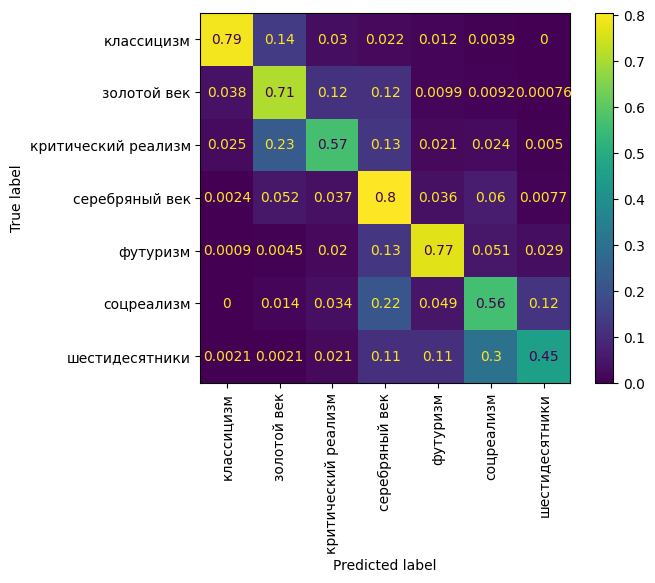

In [79]:
cm = confusion_matrix(labels, predictions, normalize='true')
ConfusionMatrixDisplay(
    cm,
    display_labels=label_encoder.decode(np.arange(7))
).plot(xticks_rotation = 'vertical')

## Сохранение модели

In [53]:
model.save_pretrained('rubert-tiny-poems')
tokenizer.save_pretrained('rubert-tiny-poems')

('rubert-tiny-poems/tokenizer_config.json',
 'rubert-tiny-poems/special_tokens_map.json',
 'rubert-tiny-poems/vocab.txt',
 'rubert-tiny-poems/added_tokens.json',
 'rubert-tiny-poems/tokenizer.json')

In [54]:
!zip -r rubert-tiny-poems.zip rubert-tiny-poems

  adding: rubert-tiny-poems/ (stored 0%)
  adding: rubert-tiny-poems/tokenizer_config.json (deflated 73%)
  adding: rubert-tiny-poems/config.json (deflated 70%)
  adding: rubert-tiny-poems/model.safetensors (deflated 8%)
  adding: rubert-tiny-poems/special_tokens_map.json (deflated 80%)
  adding: rubert-tiny-poems/tokenizer.json (deflated 73%)
  adding: rubert-tiny-poems/vocab.txt (deflated 64%)


## Использование

In [55]:
!pip install transformers

In [56]:
!unzip rubert-tiny-poems.zip

Archive:  rubert-tiny-poems.zip
replace rubert-tiny-poems/tokenizer_config.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: rubert-tiny-poems/tokenizer_config.json  
  inflating: rubert-tiny-poems/config.json  
  inflating: rubert-tiny-poems/model.safetensors  
  inflating: rubert-tiny-poems/special_tokens_map.json  
  inflating: rubert-tiny-poems/tokenizer.json  
  inflating: rubert-tiny-poems/vocab.txt  


In [57]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

use_tokenizer = AutoTokenizer.from_pretrained('rubert-tiny-poems')
use_model = AutoModelForSequenceClassification.from_pretrained('rubert-tiny-poems')
if torch.cuda.is_available():
    use_model.cuda()

In [60]:
def get_poem_epoch(text):
    with torch.no_grad():
        inputs = use_tokenizer(text, return_tensors='pt', truncation=True, padding=True).to(use_model.device)
        probs = torch.sigmoid(use_model(**inputs).logits).cpu().numpy()[0]
    return use_model.config.id2label[probs.argmax()]

In [65]:
# Пушкин А. С., "19 октября 1825", Золотой век
get_poem_epoch('''
Роняет лес багряный свой убор,
Сребрит мороз увянувшее поле,
Проглянет день как будто поневоле
И скроется за край окружных гор.
Пылай, камин, в моей пустынной келье;
А ты, вино, осенней стужи друг,
Пролей мне в грудь отрадное похмелье,
Минутное забвенье горьких мук.
Печален я: со мною друга нет,
С кем долгую запил бы я разлуку,
Кому бы мог пожать от сердца руку
И пожелать веселых много лет.
Я пью один; вотще воображенье
Вокруг меня товарищей зовет;
Знакомое не слышно приближенье,
И милого душа моя не ждет.
''')

'золотой век'

In [66]:
# Волошин М. А., "Демоны глухонемые", Серебряный век
get_poem_epoch('''
Они проходят по земле
Слепые и глухонемые
И чертят знаки огневые
В распахивающейся мгле.

Собою бездны озаряя,
Они не видят ничего,
Они творят, не постигая
Предназначенья своего.

Сквозь дымный сумрак преисподней
Они кидают вещий луч...
Их судьбы – это лик Господний,
Во мраке явленный из туч.
''')

'серебряный век'

In [67]:
# Маяковский В. В., "Стихи о советском паспорте", футуризм
# (нарочно без "лесенки")
get_poem_epoch('''
И вдруг, как будто ожогом, рот
скривило господину.
Это господин чиновник берет
мою краснокожую паспортину.
Берет — как бомбу, берет — как ежа,
как бритву обоюдоострую,
берет, как гремучую в 20 жал
змею двухметроворостую.
Моргнул многозначаще глаз носильщика,
хоть вещи снесет задаром вам.
Жандарм вопросительно смотрит на сыщика,
сыщик на жандарма.
С каким наслажденьем жандармской кастой
я был бы исхлестан и распят
за то, что в руках у меня молоткастый,
серпастый советский паспорт.
Я волком бы выгрыз бюрократизм.
К мандатам почтения нету.
К любым чертям с матерями катись
любая бумажка. Но эту…
Я достаю из широких штанин
дубликатом бесценного груза.
Читайте, завидуйте, я — гражданин
Советского Союза.
''')

'футуризм'

In [68]:
# Симонов К. М., "Жди меня", соцреализм
get_poem_epoch('''
Жди меня, и я вернусь,
Не желай добра
Всем, кто знает наизусть,
Что забыть пора.
Пусть поверят сын и мать
В то, что нет меня,
Пусть друзья устанут ждать,
Сядут у огня,
Выпьют горькое вино
На помин души…
Жди. И с ними заодно
Выпить не спеши.
Жди меня, и я вернусь,
Всем смертям назло.
Кто не ждал меня, тот пусть
Скажет: — Повезло.
Не понять, не ждавшим им,
Как среди огня
Ожиданием своим
Ты спасла меня.
Как я выжил, будем знать
Только мы с тобой, —
Просто ты умела ждать,
Как никто другой.
''')

'серебряный век'

In [69]:
# Твардовский А. Т., "Василий Теркин" (8. Гармонь), соцреализм
get_poem_epoch('''
По дороге прифронтовой,
Запоясан, как в строю,
Шел боец в шинели новой,
Догонял свой полк стрелковый,
Роту первую свою.
Шел легко и даже браво
По причине по такой,
Что махал своею правой,
Как и левою рукой.
Отлежался. Да к тому же
Щелкал по лесу мороз,
Защемлял в пути все туже,
Подгонял, под мышки нес.
Вдруг — сигнал за поворотом,
Дверцу выбросил шофер,
Тормозит:
— Садись, пехота,
Щеки снегом бы натер.
''')

'соцреализм'